In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

#from jupyterthemes import jtplot
#jtplot.style(theme='solarizedd', context='notebook',
#             ticks=True, grid=False)

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:6'

FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0


In [2]:
log_z = np.log(states[:,2])

MU_X = np.mean(log_z)
signal = log_z-MU_X

M = signal.shape[0] - int(FREERUN/DT)
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(states[:TRAINLENGTH+TEST,2]) - \
         np.min(states[:TRAINLENGTH+TEST,2])
STD = np.std(states[:TRAINLENGTH+TEST,2])

BINS = 50

print(f'Signal length M={M}')
print(f'Normalizing value max-min id {MINMAX:.3f}')
print(f'Normalizing value max-min id {STD:.3f}')

Signal length M=15000
Normalizing value max-min id 46.872
Normalizing value max-min id 8.567


In [3]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [4]:
import json
from json import JSONEncoder

# numpy arrays cannot be written to json 
# convert to list
class NumpyArrayEncoder(JSONEncoder):
    def default(self,obj):
        if isinstance(obj,np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self,obj)
    

In [ ]:
#min_a, max_a = .55, .7
#min_sr, max_sr = .8, 1.
#min_g, max_g = 1.4, 1.7
#min_ri, max_ri = .001, 4.
#min_rr, max_rr = .001, 4.
min_a, max_a = .7, 1.
min_sr, max_sr = 1.5, 3.
min_g, max_g = .001, 2.
min_ri, max_ri = .3, 3.5
min_rr, max_rr = .4, 4.

space = [Real(min_a, max_a, name='a'),
         Real(min_sr, max_sr, name='sr'),
         Real(min_ri, max_ri, name='ri'),
         Real(min_rr, max_rr, name='rr')
        ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,ri=1.0,rr=1.0):
    start = time.time()
    amp = 1.
    global running_error, s, counter, signal, N, ref, rn, \
           alphas, rhos, gammas, inScales, resScales, dict_model, \
           model_counter, error_per_N, error_over_N, best_N_model
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype, device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 

    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+int(FREERUN/DT),1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+int(FREERUN/DT)):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0).to(DEVICE)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(np.exp(signal[TRAINLENGTH:TRAINLENGTH+TEST]+MU_X),
                          np.exp(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]+MU_X),
                          MINMAX) 
    except:
        pass
    
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse + dist
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000
    
    if((loss < running_error) and (nrmse < .3)):
        print(f'Dist {dist:3f}')
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        if(error_over_N > running_error):
            print('\n\nNew N best!!!!!!!!!!!!\n\n')
            error_over_N = running_error  #set the lowest error
            best_N_model = [N,ref,rn,counter]
            states_dict = {'States': state}
            with open(f'Dicts/States/states_Lz_{N}.json', 'w') as fp:
                json.dump(states_dict, fp, cls=NumpyArrayEncoder)
            dict_model[str(N)] = {'Wnet': wnet,
                                  'Wout': wout,
                                  'Preds': yHat_GPU,
                                  'Params': currentParams}
            print(best_N_model)
        
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-4,4)
        ax1.legend()
        plt.show()
        plt.close()
        model_counter += 1
        error_per_N.append(nrmse)
        
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f} nrmse={nrmse:3f} CD {dist:3f}')
    ####### Running info ##############################
    print(f'Iter: {counter} #### Time {(time.time()-start):.2f}',
          f' NRMSE {nrmse:.3f} CD {dist:.3f}')
    ###### Store this run #############################
    dict_counters[str(N)] = {'numModels': model_counter,
                             'meanError': np.mean(np.array(error_per_N),axis=0).tolist(),
                             'varError' : np.var(np.array(error_per_N),axis=0).tolist()}
    counter += 1
    return loss

In [ ]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)
# Skipped 1000
size = [300,50,40,30,20,10]
rand_state = [11,37,3,24,91]

dict_counters = {}
dict_model = {}
for N in size:
    model_counter = 0
    error_per_N = []
    best_N_model = [N,0,0,0]
    
    min_a, max_a = .7, 1.
    min_sr, max_sr = 1.5, 3.
    min_g, max_g = .001, 2.
    min_ri, max_ri = .3, 3.5
    min_rr, max_rr = .4, 4.
    space = [Real(min_a, max_a, name='a'),
             Real(min_sr, max_sr, name='sr'),
             Real(min_ri, max_ri, name='ri'),
             Real(min_rr, max_rr, name='rr')
            ]
    error_over_N = 1000
    for ref in range(5):
        
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []
        
        for rn in range(5):
            start = time.time()
            running_error = 1000
            counter = 0 
            print(f'********** Size {N} -- Run {rn} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=4,
                                    n_initial_points=100)
            end = time.time()-start
            print(f'End Run {rn} Time {end:.3f}')
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')
            
        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        
        
    print(f'Overall best model {best_N_model}')
    dict_counters[str(N)] = {'numModels': model_counter,
                             'meanError': np.mean(np.array(error_per_N)).tolist(),
                             'varError' : np.var(np.array(error_per_N)).tolist()}
with open('Dicts/diag_Lz.json', 'w') as fp:
    json.dump(dict_counters, fp, cls=NumpyArrayEncoder)
with open('Dicts/models_Lz.json', 'w') as fp:
    json.dump(dict_model, fp, cls=NumpyArrayEncoder)
print(dict_counters)

### Analysis

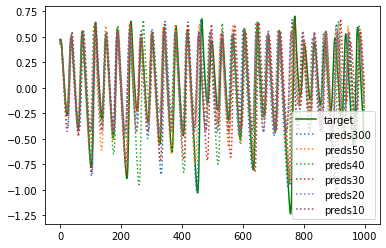

In [5]:
fpath = 'Dicts/diag_Lz.json'
with open(fpath,'r') as j:
    dict_diag = json.loads(j.read())

fpath = 'Dicts/models_Lz.json'
with open(fpath,'r') as j:
    dict_models = json.loads(j.read())

size = [300,50,40,30, 20,10]
plt.plot(signal[TRAINLENGTH:TRAINLENGTH + TEST], color='g', label='target')
for n in size:
    preds = dict_models[str(n)]['Preds']
    plt.plot(preds[TRAINLENGTH:TRAINLENGTH + TEST],
             linestyle='dotted', label=f'preds{n}')
plt.legend()
plt.show()

### Get Ranks

Alpha 0.8872706721376742 --- Gamma 1.0
Ave rank for N=300 is 9 Tolerance 1e-13 Rho A 1.65
Alpha 0.9804581386469675 --- Gamma 1.0
Ave rank for N=50 is 34 Tolerance 1e-15 Rho A 1.616
Alpha 0.7224174732267955 --- Gamma 1.0
Ave rank for N=40 is 8 Tolerance 1e-07 Rho A 1.714
Alpha 0.941839904009472 --- Gamma 1.0
Ave rank for N=30 is 6 Tolerance 0.0001 Rho A 1.724
Alpha 0.9038202520253603 --- Gamma 1.0
Ave rank for N=20 is 8 Tolerance 1e-06 Rho A 2.241
Alpha 0.9480810455960621 --- Gamma 1.0
Ave rank for N=10 is 3 Tolerance 0.1 Rho A 1.869


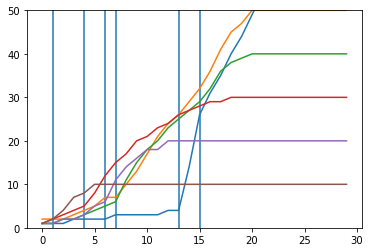

In [6]:
from scipy.optimize import fsolve
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

K = 1
L = 1
tols = [1/10**x for x in range(0,30)]
plt.figure()
for n in size:
    mat = np.array(dict_models[str(n)]['Wnet'])
    Wr, Wi = rca.get_mats(None, K,n, matrix=mat)
    # params [alpha, spectralradius, gamma, ri, rr, loss]
    p = dict_models[str(n)]['Params']
    a,g = p[0], p[2]
    print(f'Alpha {a} --- Gamma {g}')
    x0 = np.zeros((n,1))
    u0 = np.zeros((K,1))
    A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
    B = rca.partial_u(x0, u0, a, g, Wi, Wr)
    rhoA = np.max(np.abs(rca.eig_spectrum(A)))
    Cn = np.nan_to_num(rca.reachable_matrix(A,B))
    if(K != 3): # Square Cn
        Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))
    else:            # Non-square Cn
        Cn = Cn/np.max(np.abs(np.linalg.svd(Cn, compute_uv=False)))

    rkc = rank_curve(Cn, tols)
    v = np.argmax(np.gradient(rkc))-1
    plt.plot(rkc, label=f'N={n}')
    plt.vlines([v],0,50)
    ave_rank = (rkc[v]+rkc[v+1])//2
    print(f'Ave rank for N={n} is {ave_rank} Tolerance {tols[v]} Rho A {rhoA.round(3)}')
plt.ylim(0,50)
plt.show()

In [7]:
fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

### Get divergence

k-size=30 Trainingset min=0.962  threshold=0.914  Location=308


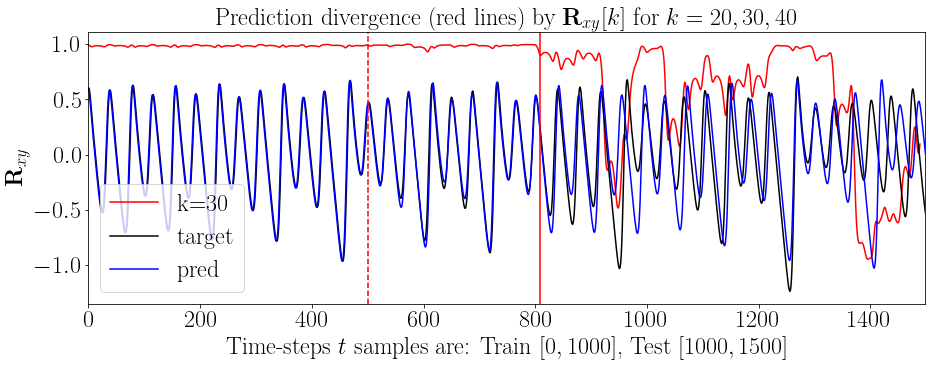

In [9]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))

thresh = []
start = TRAINLENGTH - 1000
stop = M+FREERUN
k_list = [30]
plt.figure(figsize=(15,5))
for k in k_list:
    lengthTC = (stop-start)-k
    trainCorr = np.zeros(lengthTC) # 21000-k
    pred = np.array(dict_models[str(k)]['Preds'])
    for j in range(start,stop-k):
        tar = signal[j:j+k].reshape((k,1))
        prd = pred[j:j+k].reshape((k,1))
        trainCorr[j-start] = Rxy(tar,prd)
    minVal = trainCorr[:1000].min()
    threshold = minVal*.95
    thresholdLoc = np.where(trainCorr[1000:]<threshold)[0][0]
    thresh.append(thresholdLoc)
    print(f'k-size={k} Trainingset min={minVal.round(3)}  threshold={threshold:.3f}',
          f' Location={thresholdLoc}')
    plt.plot(trainCorr[500:2000], color='r', label=f'k={k}')
plt.plot(signal[TRAINLENGTH-500:TRAINLENGTH+TEST], color='k', label='target')
plt.plot(pred[TRAINLENGTH-500:TRAINLENGTH+TEST],color='b', label='pred')
plt.axvline(500+thresholdLoc,color='r')
plt.axvline(500,color='r',linestyle='dashed')
plt.ylabel('$\mathbf{R}_{xy}$')
plt.xlabel('Time-steps $t$ samples are: Train $[0,1000]$, Test $[1000,1500]$')
plt.legend(fontsize=24,loc='lower left')
plt.title('Prediction divergence (red lines) by $\mathbf{R}_{xy}[k]$ for $k=20,30,40$')
plt.show()

### Chaos plot

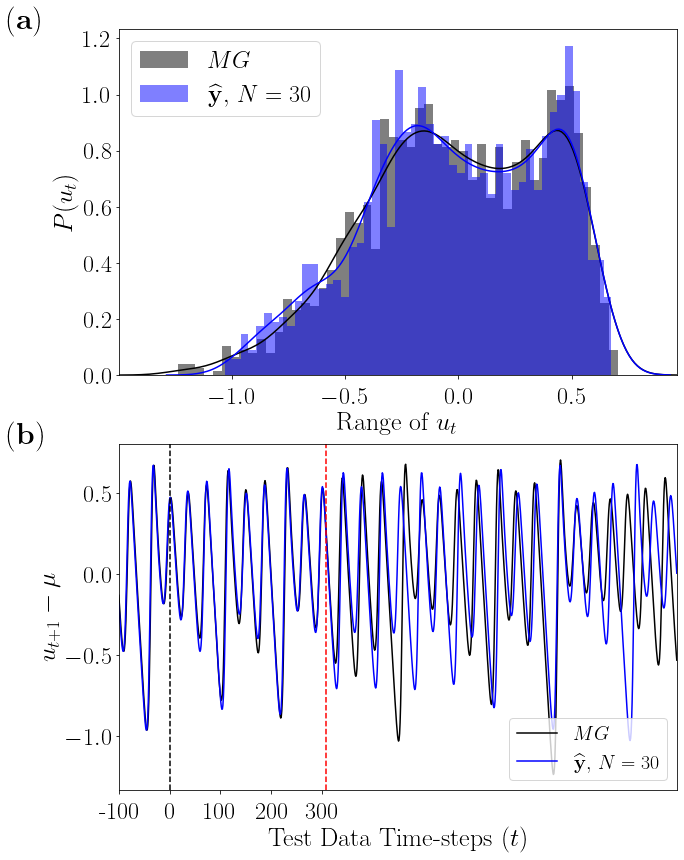

In [12]:
import seaborn as sns
import pandas as pd
def rank_along_trajectory(wr, wi, a, g, forcing, n, k, tolerance, delX):
    T = forcing.shape[0]
    ranks = np.zeros(T)
    conds = np.zeros(T)
    radii = np.zeros(T)
    uncertainty = np.zeros((n,T))
    def Func(x):
        return np.squeeze(-x.reshape(n,1) + (1-a)*x.reshape(n,1) +\
                          a*g*np.tanh(np.dot(wr,x.reshape(n,1)) +\
                         (np.dot(wi,ueq.reshape(k,1)).reshape(n,1))))
    for i in range(T):
        ueq = forcing[i]
        x0 = np.ones((n,1))*.5
        xeq = (fsolve(Func,x0)).reshape(n,1)
        A = rca.leaky_jacobian(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        radii[i] = np.max(np.abs(rca.eig_spectrum(A)))
        conds[i] = rca.condition_number(A)[0]
        B = rca.partial_u(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        uncertainty[:,i] = np.squeeze(np.dot(A,delX))
        Cplus = rca.controllability_matrix(A, B)
        ranks[i] = rca.rank(Cplus, tolerance)
        print(f'Time-step: {i} Rank: {ranks[i]} Uncertainty: {np.linalg.norm(uncertainty):.2f}  CondNum: {conds[i]:.2f}')
    return ranks, uncertainty, conds, radii




n=30
pred = np.array(dict_models[str(n)]['Preds'])
data_dict = {'y': signal[14000:],
             'yh': np.squeeze(pred[14000:]),
            }
alpha = .5
bins = 50
df = pd.DataFrame(data=data_dict)
fig= plt.figure(figsize=(10,14))
ax1 = plt.subplot(211)
sns.distplot(df['y'],
             label='$MG$',
             bins=bins,
             color='k',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=.5))
sns.distplot(df['yh'],
             label='$\widehat{\mathbf{y}},\,N=30$',
             bins=bins,
             color='b',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=alpha))
plt.legend(loc='upper left', fontsize=fontsize)
plt.ylabel(r'${P}(u_t)$', fontsize=26,  color='black', weight='heavy')
plt.xlabel(r'Range of $u_t$', fontsize=26,  color='black', weight='heavy')
plt.xticks(c='black', fontsize=fontsize)
plt.yticks(c='black', fontsize=fontsize)
ax1.text(-0.2, 1.,s='$(\mathbf{a})$', transform=ax1.transAxes, 
            size=30, weight='bold')

ax2 = plt.subplot(212)
plt.rcParams['xtick.major.pad']='8'
ax2.text(-0.2, 1.,s='$(\mathbf{b})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax2.plot(signal[TRAINLENGTH-100:TRAINLENGTH+TEST],'k', label=r'$MG$')
ax2.plot(pred[TRAINLENGTH-100:TRAINLENGTH+TEST],'b-', label='$\widehat{\mathbf{y}},\,N=30$')
ax2.axvline(100, c='k',ls='dashed' )
ax2.axvline(100+thresholdLoc, c='r',ls='dashed' )
ax2.legend(loc='lower right',fontsize=20)
ax2.set_xticks([0,100,200,300,400])
ax2.set_xticklabels([-100,0,100,200,300])
ax2.set_xlabel('Test Data Time-steps '+'($t$)', fontsize=26, color='black', weight='heavy')
ax2.set_ylabel(r'${u_{t+1} - \mu}$', fontsize=26, color='black', weight='heavy')

plt.show()